<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="250" align="center">

*TRABAJO FINAL - VISIÓN POR COMPUTADORA II - JUAN I. MUNAR*

#### **SKIN CANCER: HAM10000**
#### CONCLUSIÓN - MODELO FINAL - RESNET18 ENTRENAMIENTO COMPLETO

**OBJETIVO.** Se continuará el análisis iniciado en las partes 1 y 2 realizando undersampling y oversampling y entrenando todos los parámetros de una red ResNet18 que es la menos profunda de las arquitecturas ResNet lo que resulta conveniente en tiempos de cómputo. 

##### **1. IMPORTACIÓN Y PRETRATAMIENTO DE DATOS**

In [1]:
# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import os

In [2]:
# Ubicaciones y df con One Hot Encoding de clases para cada imagen
image_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
mask_dir = "/kaggle/input/ham1000-segmentation-and-classification/masks"
df = pd.read_csv("/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv")

In [3]:
# Obtención de labels de las columnas
df['label'] = df.drop(columns = ["image"], axis = 1).idxmax(axis=1)

In [4]:
# Ordeno las columnas
orden_columnas = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC', 'image', 'label']
clases = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
df = df[orden_columnas]

In [5]:
# Creo directorios en kaggle
!mkdir -p datasets/train datasets/test
%cd /kaggle/working/datasets/train
!mkdir AKIEC BCC BKL DF MEL NV VASC
%ls

%cd /kaggle/working/datasets/test
!mkdir AKIEC BCC BKL DF MEL NV VASC
%ls

%cd /kaggle/working

/kaggle/working/datasets/train
AKIEC/  BCC/  BKL/  DF/  MEL/  NV/  VASC/
/kaggle/working/datasets/test
AKIEC/  BCC/  BKL/  DF/  MEL/  NV/  VASC/
/kaggle/working


##### **2. SPLIT Y BALANCEO DE DATOS**

In [6]:
# Recorto las clases a un valor máximo
max_size = 1000

for clase in clases:
    n_0 = sum(df[clase])
    if n_0 > max_size:
        n_filas_eliminar = int(n_0 - max_size)
        indices_eliminar = df[df[clase] == 1].sample(n_filas_eliminar).index
        df = df.drop(indices_eliminar)
df.label.value_counts()

label
NV       1000
BKL      1000
MEL      1000
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64

In [7]:
# Divido el dataframe en X (nombre de las imágenes) e y (clase)
from sklearn.model_selection import train_test_split
X = df['image']
y = df
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    df,
                                                    test_size=0.1,
                                                    random_state=42,
                                                    stratify=df['label'])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Hago un oversampling de las clases minoritarias.

In [8]:
# Resampleo categóricamente (SMOTEN)
from imblearn.over_sampling import SMOTEN
sampler = SMOTEN(random_state=0)
X = y_train.drop(columns=['label'], axis=1)
y = y_train['label']

X_res, y_res = sampler.fit_resample(X, y)

In [9]:
# Actualizo X_train
X_train = X_res['image']

In [10]:
# Importo las imágenes
import shutil
for clase in clases:
    imgs_name = X_train[X_res[clase]==1].to_list()
    for img in imgs_name:
        shutil.copy(f'/kaggle/input/ham1000-segmentation-and-classification/images/{img}.jpg',
                    f'/kaggle/working/datasets/train/{clase}')

for clase in clases:
    imgs_name = X_test[y_test[clase]==1].to_list()
    for img in imgs_name:
        shutil.copy(f'/kaggle/input/ham1000-segmentation-and-classification/images/{img}.jpg',
                    f'/kaggle/working/datasets/test/{clase}')

In [11]:
# Chequeo el split
%ls /kaggle/working/datasets/train/*/* | wc -l
%ls /kaggle/working/datasets/test/*/* | wc -l

3688
410


##### **3. ENTRENAMIENTO DEL MODELO**

Se probarán a continuación entrenar todos los parámetros de una red ResNet18, se partirá desde los pesos preentrenados.

Es la intención realizar data augmentation en todos los casos para tener más datos a la vez que se tengan en cuenta diferencias de coloración, rotación, tamaño, etc. Se incluye este paso para cada punto en particular para adaptar las imágenes a los modelos preentrenados.

Los detalles de la red se pueden encontrar en [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [12]:
# Importo ResNet18
import torch
from torchvision import models
from torchvision.models import resnet18

# Ruta al archivo del modelo preentrenado en Kaggle
modelo_ruta = "/kaggle/input/resnet18/resnet18-f37072fd.pth"

# Cargar el modelo desde el archivo
resnet18_model = models.resnet18(weights=None)
state_dict = torch.load(modelo_ruta)
resnet18_model.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilizo la versión v2 de torchvision.transform
transform_train = v2.Compose([
    v2.RandomResizedCrop(256),
    v2.RandomHorizontalFlip(0.5),
    v2.ColorJitter(saturation=0.1, hue=0.1),
    v2.RandomRotation(45),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# Transformaciones de test
transform_test = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(256),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# Cargo datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/train',
    transform=transform_train
)
test_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/test',
    transform=transform_test
)

# Cargo DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    #sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    #sampler=test_sampler,
    shuffle=True,
    num_workers=4
)

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [14]:
# A mover todas las capas de la red
for param in resnet18_model.parameters():
    param.requires_grad = True

In [15]:
# Observemos las versión corta de la arquitectura
for name, layer in resnet18_model.named_children():
    print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [16]:
# Modifico la última capa para adaptarse al número de clases de tu conjunto de datos
import torch.nn as nn

num_classes = len(train_dataset.classes)
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(
    in_features=last_layer_in_features,
    out_features=num_classes
)

In [17]:
# Importo el tiempo para medir cuánto tarda cada epoch
import time

In [18]:
# Defino la función de entrenamiento
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model,
                               torch.zeros((1, 3, data["image_width"],
                                            data["image_height"])))
        valid_writer.add_graph(model,
                               torch.zeros((1, 3, data["image_width"],
                                            data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_met = []
    valid_loss = []
    valid_met = []

    best_val_loss = float('inf')

    for epoch in range(epochs):
        start_time = time.time()

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_metric = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            metric_ = metric(output, train_target)
            epoch_train_metric += metric_.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_metric = epoch_train_metric / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_met.append(epoch_train_metric)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_metric = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_metric += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_metric = epoch_valid_metric / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_met.append(epoch_valid_metric)

        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            best_params = model.state_dict()
        
        end_time = time.time() 
        epoch_time = end_time - start_time
        
        print("Epoch: {}/{} - Tiempo: {:.2f} seg - Train loss {:.6f} - Train metric {:.6f} - Valid Loss {:.6f} - Valid metric {:.6f}".format(
        epoch+1, epochs, epoch_time, epoch_train_loss, epoch_train_metric, epoch_valid_loss, epoch_valid_metric))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("metric", epoch_train_metric, epoch)
            valid_writer.add_scalar("metric", epoch_valid_metric, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_met"] = train_met
    history["valid_loss"] = valid_loss
    history["valid_met"] = valid_met

    torch.save(best_params, 'best_model_params.pth')

    return history

In [19]:
# Alto y ancho de imágenes
H = 256
W = 256

In [21]:
# Corremos el entrenamiento
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.F1Score(task='multiclass', num_classes=num_classes)
data = {"train": train_loader,
        "valid": test_loader,
        "image_width": W,
        "image_height": H}
epochs = 100
writer = {"train": SummaryWriter(log_dir="transfer_learning_RN50/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_RN50/valid")}

history = train(resnet18_model,
                optimizer,
                loss,
                metric,
                data,
                epochs,
                writer)

Epoch: 1/100 - Tiempo: 29.75 seg - Train loss 1.770289 - Train metric 0.282381 - Valid Loss 1.593853 - Valid metric 0.360749
Epoch: 2/100 - Tiempo: 25.45 seg - Train loss 1.443966 - Train metric 0.481250 - Valid Loss 1.354476 - Valid metric 0.464457
Epoch: 3/100 - Tiempo: 25.04 seg - Train loss 1.292995 - Train metric 0.528448 - Valid Loss 1.212504 - Valid metric 0.525412
Epoch: 4/100 - Tiempo: 25.40 seg - Train loss 1.192988 - Train metric 0.562931 - Valid Loss 1.094250 - Valid metric 0.562328
Epoch: 5/100 - Tiempo: 25.34 seg - Train loss 1.110536 - Train metric 0.596606 - Valid Loss 1.067138 - Valid metric 0.573832
Epoch: 6/100 - Tiempo: 24.87 seg - Train loss 1.053956 - Train metric 0.613254 - Valid Loss 0.996863 - Valid metric 0.594780
Epoch: 7/100 - Tiempo: 25.39 seg - Train loss 0.994511 - Train metric 0.635560 - Valid Loss 0.930237 - Valid metric 0.632212
Epoch: 8/100 - Tiempo: 26.08 seg - Train loss 0.970476 - Train metric 0.641703 - Valid Loss 0.925997 - Valid metric 0.627060


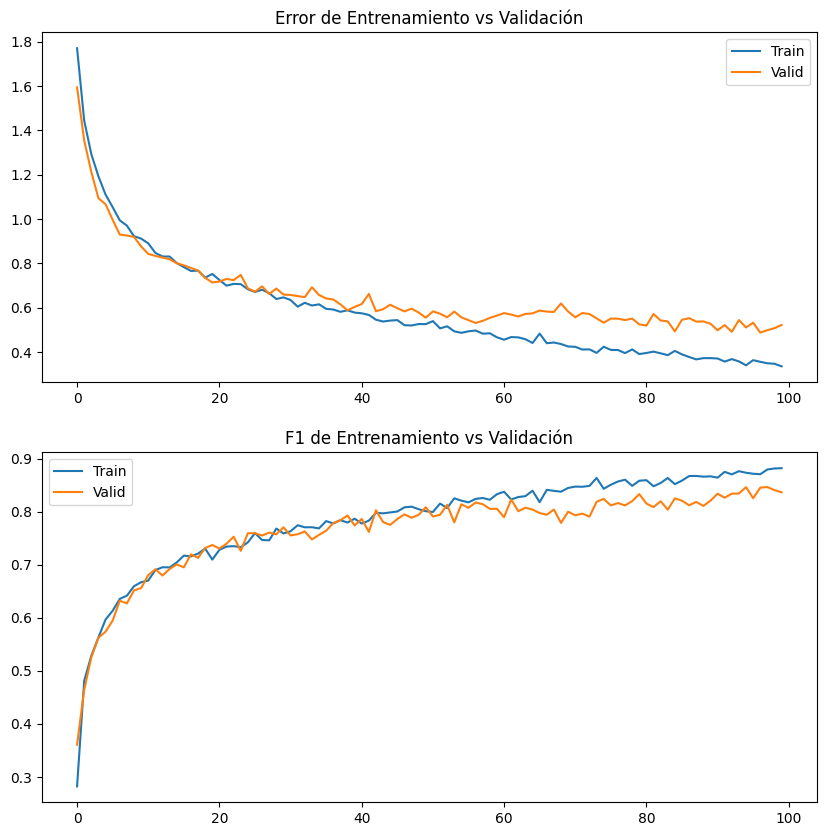

In [22]:
# Ploteo
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_met"])
axs[1].plot(history["valid_met"])
axs[1].title.set_text('F1 de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [23]:
# Cargo los mejores parámetros (min loss)
best_model_params = torch.load('best_model_params.pth')
resnet18_model.load_state_dict(best_model_params)

<All keys matched successfully>

In [24]:
# Evaluación del accuracy y Confusion Matrix
from torchmetrics.classification import MulticlassConfusionMatrix

all_labels = []
all_preds = []

# Todo debe correr en el mismo sitio
device = 'cuda'

# Aseguro el modelo en evaluation
resnet18_model.to(device)
resnet18_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

confmat = MulticlassConfusionMatrix(num_classes=num_classes)
confmat(torch.tensor(all_preds),
        torch.tensor(all_labels))

tensor([[24,  2,  2,  1,  3,  1,  0],
        [ 1, 46,  0,  0,  1,  2,  1],
        [ 4,  5, 88,  0,  1,  2,  0],
        [ 1,  0,  1,  9,  0,  1,  0],
        [ 3,  2, 10,  0, 70, 14,  1],
        [ 0,  1,  1,  0,  4, 94,  0],
        [ 0,  0,  1,  0,  0,  0, 13]])

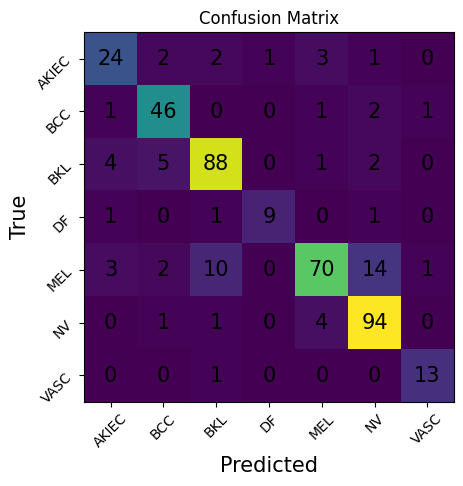

In [25]:
# Ploteo la matriz de confusion
ax_ = clases
fig_, ax_ = confmat.plot()

plt.xlabel("Predicted")
plt.ylabel("True")

ax_.set_xticklabels(clases)
plt.xticks(rotation=45)
ax_.set_yticklabels(clases)
plt.yticks(rotation=45)

plt.title("Confusion Matrix")
plt.show()

In [26]:
# Evaluación del accuracy
resnet18_model.eval()

correctas = 0
total = 0
device = 'cuda'

with torch.no_grad():
    for imagenes, etiquetas in test_loader:
        imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
        salidas = resnet18_model(imagenes)
        _, predicciones = torch.max(salidas.data, 1)
        total += etiquetas.size(0)
        correctas += (predicciones == etiquetas).sum().item()

# Calcular el accuracy
accuracy = correctas / total
print(f'Accuracy en el conjunto de pruebas: {accuracy * 100:.2f}%')

Accuracy en el conjunto de pruebas: 83.90%


In [27]:
resnet18_model.eval()  # Asegurarte de que el modelo esté en modo de evaluación
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_model.to(device)

correct_predictions_per_class = {i: 0 for i in range(num_classes)}
total_samples_per_class = {i: 0 for i in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet18_model(inputs)
        _, predicted_classes = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            prediction = predicted_classes[i].item()
            total_samples_per_class[label] += 1
            correct_predictions_per_class[label] += int(label == prediction)

class_accuracies = {}
for class_label, correct_predictions in correct_predictions_per_class.items():
    total_samples = total_samples_per_class[class_label]
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    class_accuracies[class_label] = accuracy

for class_label, accuracy in class_accuracies.items():
    print(f'Accuracy for Class {clases[class_label]}: {accuracy:.2%}')

Accuracy for Class AKIEC: 72.73%
Accuracy for Class BCC: 90.20%
Accuracy for Class BKL: 88.00%
Accuracy for Class DF: 75.00%
Accuracy for Class MEL: 70.00%
Accuracy for Class NV: 94.00%
Accuracy for Class VASC: 92.86%


In [28]:
# Salvo el modelo y el estado del optimizador
ruta_modelo_completo = '/kaggle/working/resnet18'
torch.save({
    'modelo_estado_dict': resnet18_model.state_dict(),
    'optimizador_estado_dict': optimizer.state_dict(),
}, ruta_modelo_completo)

##### **4. CONCLUSIONES**

El modelo entrenado sobre el dataset balanceado y afectando todos sus parámetros presenta un funcionamiento que se puede considerar correcto. Un médico a simple vista puede diagnosticar con un accuracy del 60%, en este modelo sencillo obtuvo métricas superiores salvo para la clase DF que es benigna. De las curvas se desprende que todavía tiene margen con más epochs el modelo.